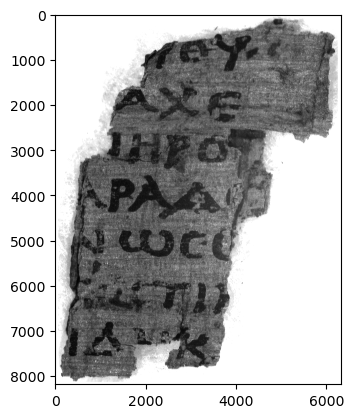

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import glob
import PIL.Image as Image
import torch.utils.data as data
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from tqdm import tqdm
from ipywidgets import interact, fixed

PREFIX = '/vesuvius-challenge/train/1/'
BUFFER = 30  # Buffer size in x and y direction
Z_START = 27 # First slice in the z direction to use
Z_DIM = 10   # Number of slices in the z direction
TRAINING_STEPS = 30000
LEARNING_RATE = 0.03
BATCH_SIZE = 32
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

plt.imshow(Image.open(PREFIX+"ir.png"), cmap="gray")

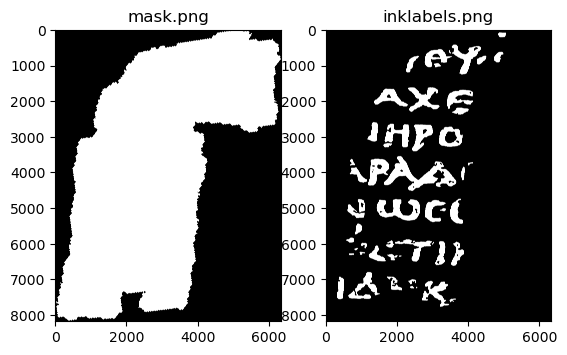

In [2]:
mask = np.array(Image.open(PREFIX+"mask.png").convert('1'))
label = torch.from_numpy(np.array(Image.open(PREFIX+"inklabels.png"))).gt(0).float().to(DEVICE)
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.set_title("mask.png")
ax1.imshow(mask, cmap='gray')
ax2.set_title("inklabels.png")
ax2.imshow(label.cpu(), cmap='gray')
plt.show()

100%|██████████| 10/10 [00:15<00:00,  1.59s/it]


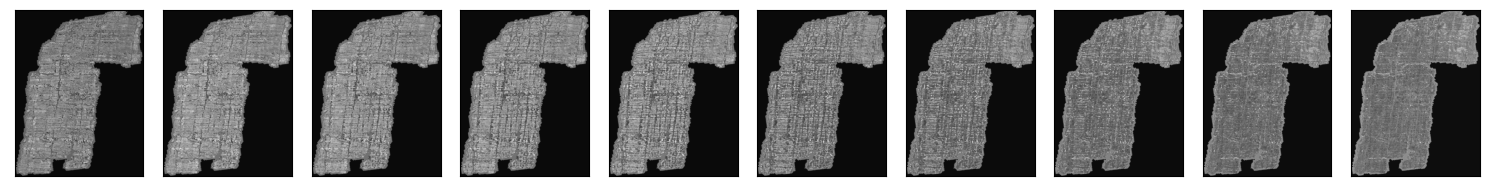

In [3]:
# Load the 3d x-ray scan, one slice at a time
images = [np.array(Image.open(filename), dtype=np.float32)/65535.0 for filename in tqdm(sorted(glob.glob(PREFIX+"surface_volume/*.tif"))[Z_START:Z_START+Z_DIM])]
image_stack = torch.stack([torch.from_numpy(image) for image in images], dim=0).to(DEVICE)

fig, axes = plt.subplots(1, len(images), figsize=(15, 3))
for image, ax in zip(images, axes):
  ax.imshow(np.array(Image.fromarray(image).resize((image.shape[1]//20, image.shape[0]//20)), dtype=np.float32), cmap='gray')
  ax.set_xticks([]); ax.set_yticks([])
fig.tight_layout()
plt.show()

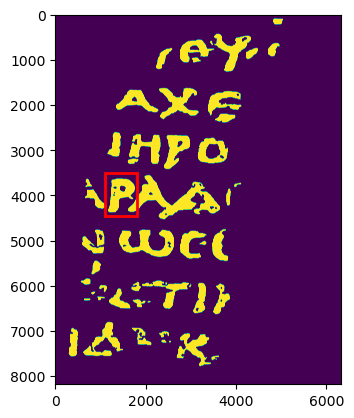

In [4]:
rect = (1100, 3500, 700, 950)
fig, ax = plt.subplots()
ax.imshow(label.cpu())
patch = patches.Rectangle((rect[0], rect[1]), rect[2], rect[3], linewidth=2, edgecolor='r', facecolor='none')
ax.add_patch(patch)
plt.show()

In [5]:
class SubvolumeDataset(data.Dataset):
    def __init__(self, image_stack, label, pixels):
        self.image_stack = image_stack
        self.label = label
        self.pixels = pixels
    def __len__(self):
        return len(self.pixels)
    def __getitem__(self, index):
        y, x = self.pixels[index]
        subvolume = self.image_stack[:, y-BUFFER:y+BUFFER+1, x-BUFFER:x+BUFFER+1].view(1, Z_DIM, BUFFER*2+1, BUFFER*2+1)
        inklabel = self.label[y, x].view(1)
        return subvolume, inklabel

model = nn.Sequential(
    nn.Conv3d(1, 16, 3, 1, 1), nn.MaxPool3d(2, 2),
    nn.Conv3d(16, 32, 3, 1, 1), nn.MaxPool3d(2, 2),
    nn.Conv3d(32, 64, 3, 1, 1), nn.MaxPool3d(2, 2),
    nn.Flatten(start_dim=1),
    nn.LazyLinear(128), nn.ReLU(),
    nn.LazyLinear(1), nn.Sigmoid()
).to(DEVICE)

/opt/conda/lib/python3.7/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [6]:
print("Generating pixel lists...")

not_border = np.zeros(mask.shape, dtype=bool)
not_border[BUFFER:mask.shape[0]-BUFFER, BUFFER:mask.shape[1]-BUFFER] = True
arr_mask = np.array(mask) * not_border
inside_rect = np.zeros(mask.shape, dtype=bool) * arr_mask
# Sets all indexes with inside_rect array to True
inside_rect[rect[1]:rect[1]+rect[3]+1, rect[0]:rect[0]+rect[2]+1] = True
# Set the pixels within the inside_rect to False
outside_rect = np.ones(mask.shape, dtype=bool) * arr_mask
outside_rect[rect[1]:rect[1]+rect[3]+1, rect[0]:rect[0]+rect[2]+1] = False
pixels_inside_rect = np.argwhere(inside_rect)
pixels_outside_rect = np.argwhere(outside_rect)

print("Training...")
train_dataset = SubvolumeDataset(image_stack, label, pixels_outside_rect)
train_loader = data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
criterion = nn.BCELoss()
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=LEARNING_RATE, total_steps=TRAINING_STEPS)
model.train()
# running_loss = 0.0
for i, (subvolumes, inklabels) in tqdm(enumerate(train_loader), total=TRAINING_STEPS):
    if i >= TRAINING_STEPS:
        break
    optimizer.zero_grad()
    outputs = model(subvolumes.to(DEVICE))
    loss = criterion(outputs, inklabels.to(DEVICE))
    loss.backward()
    optimizer.step()
    scheduler.step()
#     running_loss += loss.item()
#     if i % 3000 == 3000-1:
#         print("Loss:", running_loss / 3000)
#         running_loss = 0.0

Generating pixel lists...
Training...


100%|██████████| 30000/30000 [08:24<00:00, 59.41it/s]


100%|██████████| 20833/20833 [01:24<00:00, 247.92it/s]


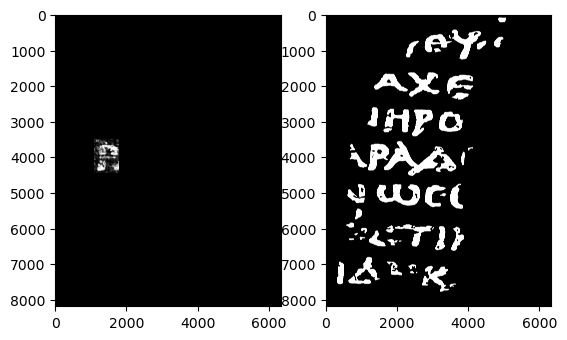

In [7]:
eval_dataset = SubvolumeDataset(image_stack, label, pixels_inside_rect)
eval_loader = data.DataLoader(eval_dataset, batch_size=BATCH_SIZE, shuffle=False)
output = torch.zeros_like(label).float()
model.eval()
with torch.no_grad():
    for i, (subvolumes, _) in enumerate(tqdm(eval_loader)):
        for j, value in enumerate(model(subvolumes.to(DEVICE))):
            output[tuple(pixels_inside_rect[i*BATCH_SIZE+j])] = value

fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(output.cpu(), cmap='gray')
ax2.imshow(label.cpu(), cmap='gray')
plt.show()

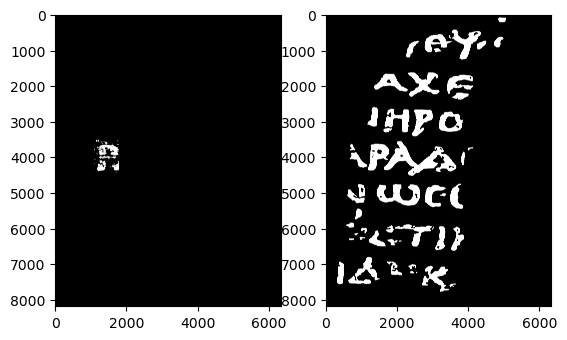

In [8]:
THRESHOLD = 0.4
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(output.gt(THRESHOLD).cpu(), cmap='gray')
ax2.imshow(label.cpu(), cmap='gray')
plt.show()

In [9]:

def rle(output):
    pixels = np.where(output.flatten().cpu() > THRESHOLD, 1, 0).astype(np.uint8)
    pixels[0] = 0
    pixels[-1] = 0
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 2
    runs[1::2] = runs[1::2] - runs[:-1:2]
    return ' '.join(str(x) for x in runs)
rle_output = rle(output)
# This doesn't make too much sense, but let's just output in the required format
# so notebook works as a submission. :-)
print("Id,Predicted\na," + rle_output + "\nb," + rle_output, file=open('submission.csv', 'w'))